In this notebook we are going to compute different connectivity measures and aggregate them into a dataframe. 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import mne_connectivity
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
import os 
import joblib
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [5]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

# subj_df = subj_df[subj_df.Site=='UI']
subj_df = subj_df[~subj_df['MSSMCode'].isin(['MS015', 'MS024', 'MS034', 'MS038'])]


days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [6]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df_RWH.csv')
combined_df = pd.read_csv(f'{load_dir}/full_df_RWH.csv')

## Example: computing coherence

In [ ]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

evs = {'gamble_start':[-1.0, 0], 
       'feedback_start': [0, 1.5]}

analysis_evs = ['feedback_start']

day = 'Day1'

for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')

In [ ]:
metric = 'coh'
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))

freq_dict = {'theta':[2, 8], 
            'alpha':[8, 13],
            'beta': [13, 30], 
            'hfa': [70, 200]}

band0 = 'theta'
# don't really need this second term unless looking cross-frequency, but it's hard-coded in  
band1 = band1

buf_ms = 1000
n_surr = 500

savepath = f'/sc/arion/projects/guLab/Salman/EphysAnalyses/Connectivity/scratch/{metric}'
if not os.path.exists(savepath):
    os.makedirs(savepath)

In [ ]:
# Example here: All-to-amygdala coherence 

pairs = (['AMY', 'HPC'], ['AMY', 'OFC'], ['AMY', 'dmPFC'], ['AMY', 'ACC'])

for pair in pairs:
    source_region = pair[0]
    target_region = pair[1]
    
    # initialize the storage list 
    conn_group_data = []

    # iterate through subjects
    for subj_id in subj_ids:
        for event in analysis_evs:
            loadpath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}'
            epochs_reref = mne.read_epochs(f'{loadpath}/neural/{day}/{event}-epo.fif', preload=True) 

            # Get electrode df 
            elec_df = pd.read_csv(f'{loadpath}/Day1_reref_elec_df')

            # construct the seed-to-target mapping based on your rois - matters most for PSI as this is directional 
            seed_target_df = pd.DataFrame(columns=['seed', 'target'], index=['l', 'r'])
            for hemi in ['l', 'r']:
                seed_target_df['seed'][hemi] = np.where(elec_df.loc[elec_df.hemisphere==hemi, 'salman_region'] == source_region)[0]
#                 seed_target_df['target'][hemi] = np.where(elec_df.loc[elec_df.hemisphere==hemi, 'salman_region'].isin(target_regions))[0]    

                seed_target_df['target'][hemi] = np.where(elec_df.loc[elec_df.hemisphere==hemi, 'salman_region'] == target_region)[0]    

            seed_target_df = seed_target_df[
                        (seed_target_df['seed'].map(lambda d: len(d) > 0)) & (seed_target_df['target'].map(lambda d: len(d) > 0))]


            # for cond in conditions: 
            for hemi in ['l', 'r']:
                # first determine if ipsilateral connectivity is even possible; if not, move on. 
                # note: edit this if you want to compute contralateral connectivity 
                if hemi not in seed_target_df.index.tolist():
                    continue
                else:
                    seed_to_target = seed_target_indices(
                        seed_target_df['seed'][hemi],
                        seed_target_df['target'][hemi])
                
                if metric == 'amp':
                    pwise = oscillation_utils.compute_connectivity(epochs_reref.copy(), 
                                               band = freq_dict[band0], 
                                               metric = metric, 
                                               indices = seed_to_target, 
                                               freqs = None, 
                                               n_cycles = None,
                                               buf_ms = buf_ms, 
                                               n_surr=n_surr,
                                               avg_over_dim='time',
                                               band1 = freq_dict[band1])
                    
                elif metric == 'granger': 
                    pwise = oscillation_utils.compute_gc_tr(mne_data=epochs_reref.copy(), 
                            band=freq_dict[band0],
                            indices=seed_to_target, 
                            freqs=freqs, 
                            n_cycles=n_cycles,
                            rank=None, 
                            gc_n_lags=15, 
                            buf_ms=buf_ms, 
                            avg_over_dim='time')
                    
                else:
                    pwise = oscillation_utils.compute_connectivity(epochs_reref.copy(), 
                                               band = freq_dict[band0], 
                                               metric = metric, 
                                               indices = seed_to_target, 
                                               freqs = freqs, 
                                               n_cycles = n_cycles,
                                               buf_ms = buf_ms, 
                                               n_surr=n_surr,
                                               avg_over_dim='time',
                                               band1 = freq_dict[band1],
                                               parallelize=True)

                pwise_dfs = []

                if metric in ['gc', 'granger', 'cacoh']:
                    # no pairs here: computed over whole multivariate state space 
                    npairs=1
                else:
                    npairs = len(seed_to_target[0])
                    
                for pair in range(npairs): 
                    pwise_df = pd.DataFrame(columns=['participant', 'roi1', 'roi2', 'hemi', 'pair_label', 'metric', 'event', 'conn'])
                    pwise_df['conn'] = pwise[:, pair] 
                    pwise_df['participant'] = subj_id
                    pwise_df['age'] = subj_df[subj_df.MSSMCode==subj_id].Age.values[0]
                    pwise_df['sex'] = subj_df[subj_df.MSSMCode==subj_id].Sex.str.strip().values[0]
                    pwise_df['roi1'] = source_region
                    pwise_df['roi2'] = target_region
                    pwise_df['hemi'] = hemi 
                    pwise_df['metric'] = metric
                    pwise_df['event'] = event
                    pwise_df['band0'] = band0
                    pwise_df['band1'] =  band1
                    
                    # aggregate
                    pwise_dfs.append(pwise_df)
                pwise_dfs = pd.concat(pwise_dfs)
                conn_group_data.append(pwise_dfs)

    all_pairs_df = pd.concat(conn_group_data)
    all_pairs_df.to_csv(f'{savepath}/{source_region}_{target_region}_{metric}_{band0}_{band1}_{event}_df', index=False)



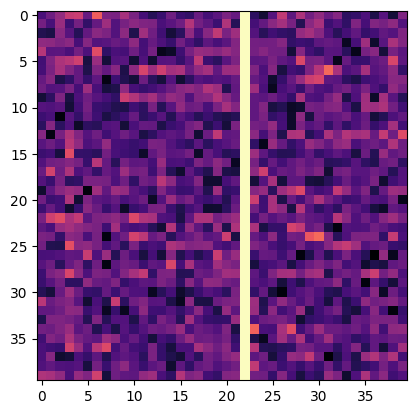

In [154]:
plt.imshow(pwise, cmap='magma')
